In [1]:
import nltk

nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package

True

In [2]:
# !pip install fastparquet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import contractions


from collections import Counter
from pathlib import Path
from typing import Iterable, Dict, List, Tuple, Any, Optional

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction import text as sktext
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS


import nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline

In [4]:
PROJECT_DIR = Path.cwd().parent
DATA_DIR = PROJECT_DIR / "data"
ARTIFACTS_DIR = PROJECT_DIR / "artifacts"

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

tweets_path = DATA_DIR / "cyberbullying_tweets.csv"
toxic_path  = DATA_DIR / "train.csv"

cyberbullying_df = pd.read_csv(tweets_path)
toxic_df = pd.read_csv(toxic_path)

print("Cyberbullying shape:", cyberbullying_df.shape)
print("Toxic shape:", toxic_df.shape)

Cyberbullying shape: (47692, 2)
Toxic shape: (159571, 8)


In [5]:
cyberbullying_df.head(10)

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying
8,@stockputout everything but mostly my priest,not_cyberbullying
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying


In [6]:
cyberbullying_df.isna().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [7]:
cyberbullying_df.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [8]:
cyberbullying_df["cyberbullying_type"].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [9]:
#check class distributions for each cyberbullying type

cyberbullying_txt_count = cyberbullying_df["cyberbullying_type"].value_counts()
cyberbullying_txt_count

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [10]:
# examples from each class
def show_examples(df, group_col, text_col="tweet_text", n=5):
    """Print n random examples per class from group_col."""
    classes = df[group_col].unique()
    for c in classes:
        print(f"\n=== {c} ===")
        samples = df.loc[df[group_col]==c, text_col].dropna().sample(n, random_state=42)
        for t in samples:
            print("-", t)

# Example tweets by each bullying type
show_examples(cyberbullying_df, "cyberbullying_type", text_col="tweet_text", n=5)


=== not_cyberbullying ===
- RT @goodfoodAU: A restaurant AND a cookbook for #mykitchenrules twins Helena and Vikki. #mkr http://t.co/jopkwkiYqH
- @Qoloob4 @Vandaliser @sajid_fairooz @IsraeliRegime I don't care about an idiot with an absurd opinion.
- @YouSoFancy oh MAN!! Not sure it gets better than Timbaland.
- The Bully at Work: What You Can Do to Stop the Hurt and Reclaim Your Dignity on the Job http://dlvr.it/bn8wZ
- @harmlesstree2 Here 11 https://t.co/xWJzpSodGj

=== gender ===
- @PouyaSaz1 yes??? the guys on my TL bashing gay marriage are the same ones who tweet rape and feminism jokes?????? like??
- Yeah I can't see her sporting Victoria's Secret wings anytime soon.    #mkr
- I’m genuinely curious. Ignoring left and right wing politics, is it okay to call a female colleague a fucking bitch? Are you supporting this behaviour? If that’s the case, nothing else needs to be said. We know all that needs to be known about you.
- Seriously? A man who openly jokes about rape and says he

In [11]:
#check whether data is balanced between bullying and not cyberbullying tweets

cyberbullying_df["is_bullying"] = (cyberbullying_df["cyberbullying_type"] != "not_cyberbullying").astype(int)
print(cyberbullying_df["is_bullying"].value_counts())

is_bullying
1    39747
0     7945
Name: count, dtype: int64


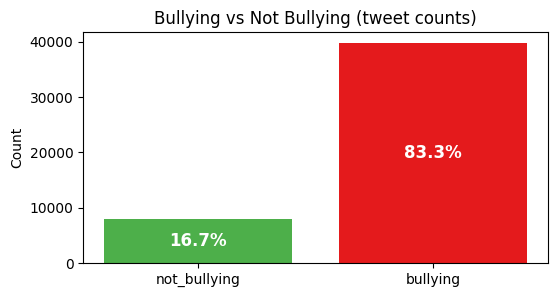

In [12]:
# Get counts and proportions
counts = cyberbullying_df["is_bullying"].value_counts().sort_index()
labels = counts.index.map({0:"not_bullying", 1:"bullying"})
total = counts.sum()

# Plot proportions
fig, ax = plt.subplots(figsize=(6,3))
bars = ax.bar(labels, counts, color=["#4daf4a", "#e41a1c"])

# Percent labels inside bars
for bar, count in zip(bars, counts):
    pct = count / total * 100
    ax.text(
        bar.get_x() + bar.get_width()/2,   # center horizontally
        bar.get_height()/2,                # center vertically
        f"{pct:.1f}%", 
        ha="center", va="center", color="white", fontsize=12, weight="bold"
    )
    
ax.set_ylabel("Count")
ax.set_title("Bullying vs Not Bullying (tweet counts)")
plt.show()

In [13]:
#check text length (tokens) by class 

cyberbullying_df["word_len"] = cyberbullying_df["tweet_text"].str.split().map(len)
cyberbullying_df.groupby("cyberbullying_type")["word_len"].describe()

,count,mean,std,min,25%,50%,75%,max
cyberbullying_type,,,,,,,,
age,7992.0,32.366366,14.935155,2.0,20.0,32.0,46.0,276.0
ethnicity,7961.0,24.889084,14.319607,1.0,15.0,22.0,30.0,329.0
gender,7973.0,23.541452,13.144091,1.0,15.0,21.0,28.0,237.0
not_cyberbullying,7945.0,13.644682,7.773285,1.0,8.0,13.0,19.0,289.0
other_cyberbullying,7823.0,14.100345,15.152781,1.0,8.0,14.0,20.0,790.0
religion,7998.0,33.421730,13.240168,2.0,21.0,36.0,45.0,96.0


<Figure size 1000x600 with 0 Axes>

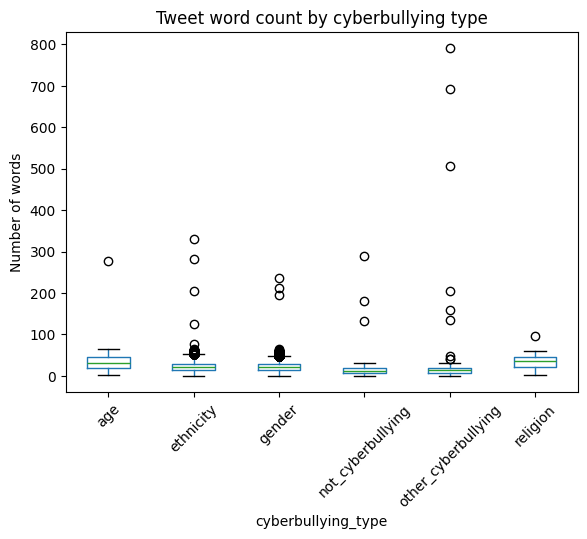

In [14]:
plt.figure(figsize=(10,6))
cyberbullying_df.boxplot(column="word_len", by="cyberbullying_type", grid=False, rot=45)
plt.suptitle("")  # removes default 'Boxplot grouped by ...' title
plt.title("Tweet word count by cyberbullying type")
plt.xlabel("cyberbullying_type")
plt.ylabel("Number of words")
plt.show()

<Figure size 1000x600 with 0 Axes>

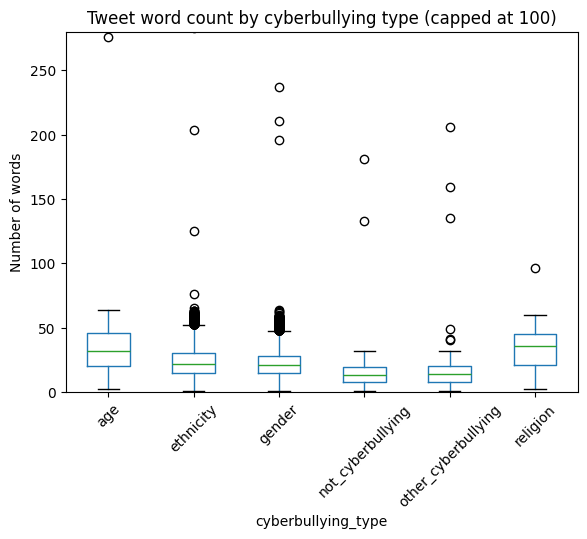

In [15]:
plt.figure(figsize=(10,6))
cyberbullying_df.boxplot(column="word_len", by="cyberbullying_type", grid=False, rot=45)
plt.ylim(0, 280)  # cap y-axis to 100 words
plt.suptitle("")
plt.title("Tweet word count by cyberbullying type (capped at 100)")
plt.xlabel("cyberbullying_type")
plt.ylabel("Number of words")
plt.show()

<Figure size 600x500 with 0 Axes>

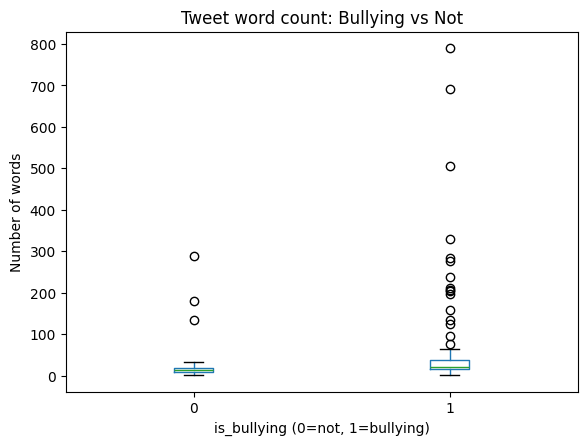

In [16]:
plt.figure(figsize=(6,5))
cyberbullying_df.boxplot(column="word_len", by="is_bullying", grid=False)
plt.suptitle("")
plt.title("Tweet word count: Bullying vs Not")
plt.xlabel("is_bullying (0=not, 1=bullying)")
plt.ylabel("Number of words")
plt.show()

In [17]:
longest_tweets = cyberbullying_df.sort_values("word_len", ascending=False).head(5)

for i, row in longest_tweets.iterrows():
    print(f"\n--- Tweet length {row.word_len} words | Type: {row.cyberbullying_type} ---\n")
    print(row.tweet_text)


--- Tweet length 790 words | Type: other_cyberbullying ---

is feminazi an actual word with a denot…
@Nasharchy my job means protecting people. even the people i don't agree with/like.
They barely cooked anything on that entrée #MKR
RT @kf: Like, no. If a community fostering jerks prevents users from adopting that community's code, it is very much a technical problem.
It's almost time. :)
@JamesGweenwood shock youre bullying me again.
@LionLionEatEat yeah, someone DMed me a screenshot. meh. let her. i have no idea who she even is.
For more egregious cases for harassment, we definitely need to be able to respond to those appropriately. But most toxicity isn't this.
So, this happened. http://t.co/ZPTRtsYFiV
@Nibelsnarfabarf @srhbutts @GRIMACHU it is really funny all the assumptions they make about how it works - and how much they are wrong.
The lack of self-awareness from @wadhwa right now is staggering and hilarious. #stopwadhwa2015
Hahahaha http://t.co/JRPkJCNVH9
This is going to be a

In [18]:
shortest_tweets = cyberbullying_df.sort_values("word_len").head(5)

for i, row in shortest_tweets.iterrows():
    print(f"\n--- Tweet length {row.word_len} words | Type: {row.cyberbullying_type} ---\n")
    print(row.tweet_text)


--- Tweet length 1 words | Type: other_cyberbullying ---

?????????

--- Tweet length 1 words | Type: not_cyberbullying ---

sociais

--- Tweet length 1 words | Type: other_cyberbullying ---

https://t.co/dTJPSIHuiF

--- Tweet length 1 words | Type: not_cyberbullying ---

http://t.co/O6tdUczw5z

--- Tweet length 1 words | Type: other_cyberbullying ---

@ivey


In [19]:
def is_only_mentions(text: str) -> bool:
    """Check if a tweet is only mentions (no real words)."""
    if not isinstance(text, str):
        return True
    # Remove mentions and whitespace
    tmp = re.sub(r"@\w+", "", text).strip()
    return tmp == ""

In [20]:
# Tweets that contain only mentions
cyberbullying_df["only_mentions"] = cyberbullying_df["tweet_text"].map(is_only_mentions)

print("Tweets that are only mentions:", cyberbullying_df["only_mentions"].sum())

Tweets that are only mentions: 20


In [21]:
# Remove tweets that are only mentions 
cyberbullying_df = cyberbullying_df.loc[cyberbullying_df["only_mentions"] == False].copy()

In [22]:
shortest = cyberbullying_df.sort_values("word_len").head(10)
for _, row in shortest.iterrows():
    print(f'--- Tweet length {row["word_len"]} words | Type: {row["cyberbullying_type"]} ---')
    print(row["tweet_text"], "\n")

--- Tweet length 1 words | Type: gender ---
😂😂😂😂😂 

--- Tweet length 1 words | Type: other_cyberbullying ---
http://t.co/lHfSu4ctGh 

--- Tweet length 1 words | Type: other_cyberbullying ---
#MKR 

--- Tweet length 1 words | Type: not_cyberbullying ---
#exercise,#cardo,#running,#bootcamp 

--- Tweet length 1 words | Type: gender ---
http://t.co/LOKtbxgMGn 

--- Tweet length 1 words | Type: other_cyberbullying ---
https://t.co/HJJ3YKIF82 

--- Tweet length 1 words | Type: other_cyberbullying ---
#TheResistance 

--- Tweet length 1 words | Type: gender ---
#mkr 

--- Tweet length 1 words | Type: other_cyberbullying ---
http://t.co/W1WmvCXAvm 

--- Tweet length 1 words | Type: other_cyberbullying ---
01:15:19:00 



In [23]:
def is_url_only(text: str) -> bool:
    text = str(text).strip()
    return bool(re.match(r"^(https?://\S+)$", text, flags=re.IGNORECASE))

# remove only url-only tweets
before = len(cyberbullying_df)
cyberbullying_df = cyberbullying_df[~cyberbullying_df["tweet_text"].map(is_url_only)].reset_index(drop=True)
after = len(cyberbullying_df)

print(f"Removed {before - after} URL-only tweets. Remaining: {after}")

Removed 82 URL-only tweets. Remaining: 47590


In [24]:
# normalize data

URL_RE = re.compile(r"http\S+|www\.\S+")
HASHTAG_RE = re.compile(r"#(\w+)")   # keep hashtag text, drop '#'


def expand_contractions(text: str) -> str:
    return contractions.fix(text)  # e.g., "don't" -> "do not"


def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text.lower()
    # expand contractions
    t = contractions.fix(t)
    # normalize mentions
    t = re.sub(r"@\S+", "@user", t)
    # remove urls
    t = URL_RE.sub(" ", t)
    # keep hashtag words
    t = HASHTAG_RE.sub(r"\1", t)
    # strip punctuation
    t = t.translate(str.maketrans("", "", string.punctuation))
    # normalize spaces
    t = re.sub(r"\s+", " ", t).strip()
    return t

cyberbullying_df["tweet_text_clean"] = cyberbullying_df["tweet_text"].map(clean_text)
cyberbullying_df[["tweet_text","tweet_text_clean"]].head(10)

,tweet_text,tweet_text_clean
0,"In other words #katandandre, your food was cra...",in other words katandandre your food was crapi...
1,Why is #aussietv so white? #MKR #theblock #ImA...,why is aussietv so white mkr theblock imaceleb...
2,@XochitlSuckkks a classy whore? Or more red ve...,user a classy whore or more red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",user meh p thanks for the heads up but not too...
4,@RudhoeEnglish This is an ISIS account pretend...,user this is an isis account pretending to be ...
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",user user yes the test of god is that good or ...
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,itu sekolah ya bukan tempat bully ga jauh kaya...
7,Karma. I hope it bites Kat on the butt. She is...,karma i hope it bites kat on the butt she is j...
8,@stockputout everything but mostly my priest,user everything but mostly my priest
9,Rebecca Black Drops Out of School Due to Bully...,rebecca black drops out of school due to bullying


The data seems very balanced across all types of cyberbullying. This shows curated sampling where each class has approximately 8000 tweets. This will help with later modeling as there will be no need for heavy resampling. 

Unlike the multiclasses, the total count of tweets that are considered bullying versus not cyberbullying are not balanced. Just under 17% of all tweets are classified as bullying. 

On average non-bullying tweets appear shorter compared to the bullying ones. However, there are some very long tweets that appear as outliers. These few extremes can skew the data. After reviewing them in details, I found that these look like concatenated tweets or scraped comments. As these seem to be real threads that are rated as bullying or not, I will keep them. For better visualization, I've created boxplots capped at 100 words. 

There are also tweets that contain only mentions that do not bring any useful information. So, if a tweet is empty after removing the mentions, those should be dropped. Moreover, the text with mentions should be normalized by replacing all mentions with @user, so that specific user names do not influence the model. 

Some tweets contain only links. The text doesn't give any bullying signal, so it might just confuse the model and create noise. 82 URL-only tweets were removed as they contain no linguistic information for the model. Hashtag-only tweets were retained since hashtags may themselves contain bullying signals.

In [25]:
negations = {"no", "not", "nor", "never"}
stop_words = set(stopwords.words("english")) - negations
lemmatizer = WordNetLemmatizer()

def collapse_token_runs(tokens, max_run=2):
    out, prev, run = [], None, 0
    for tok in tokens:
        if tok == prev:
            run += 1
        else:
            prev, run = tok, 1
        if run <= max_run:
            out.append(tok)
    return out
    

def _to_wordnet_pos(tag: str):
    if tag.startswith("J"): return wordnet.ADJ
    if tag.startswith("V"): return wordnet.VERB
    if tag.startswith("N"): return wordnet.NOUN
    if tag.startswith("R"): return wordnet.ADV
    return wordnet.NOUN  # default
    

def preprocess_nltk(text: str) -> str:
    if not isinstance(text, str): 
        return ""
    tokens = word_tokenize(text)
    tokens = collapse_token_runs(tokens, max_run=2)
    # keep alphabetic only, remove stopwords
    tokens = [t.lower() for t in tokens if t.isalpha() and t.lower() not in stop_words]
    # POS tag, then lemmatize with POS
    tagged = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(tok, _to_wordnet_pos(tag)) for tok, tag in tagged]
    return " ".join(lemmas)

# apply on your previously cleaned text column
cyberbullying_df["lemmatized_text"] = cyberbullying_df["tweet_text_clean"].map(preprocess_nltk)
cyberbullying_df[["tweet_text_clean","lemmatized_text"]].head(8)

,tweet_text_clean,lemmatized_text
0,in other words katandandre your food was crapi...,word katandandre food crapilicious mkr
1,why is aussietv so white mkr theblock imaceleb...,aussietv white mkr theblock imacelebrityau tod...
2,user a classy whore or more red velvet cupcakes,user classy whore red velvet cupcake
3,user meh p thanks for the heads up but not too...,user meh p thanks head not concern another ang...
4,user this is an isis account pretending to be ...,user isi account pretend kurdish account like ...
5,user user yes the test of god is that good or ...,user user yes test god good bad indifferent we...
6,itu sekolah ya bukan tempat bully ga jauh kaya...,itu sekolah ya bukan tempat bully ga jauh kaya...
7,karma i hope it bites kat on the butt she is j...,karma hope bite kat butt nasty mkr


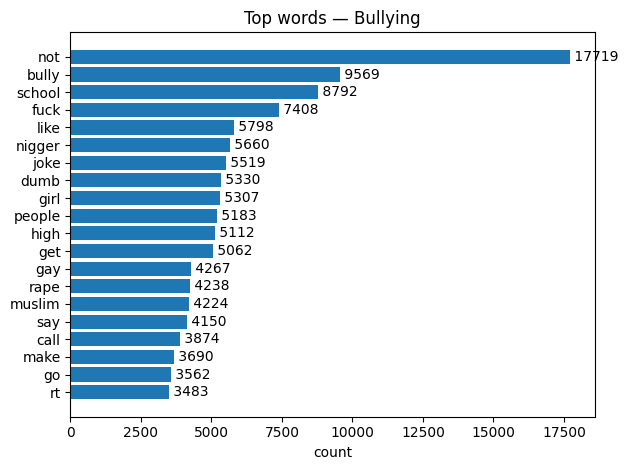

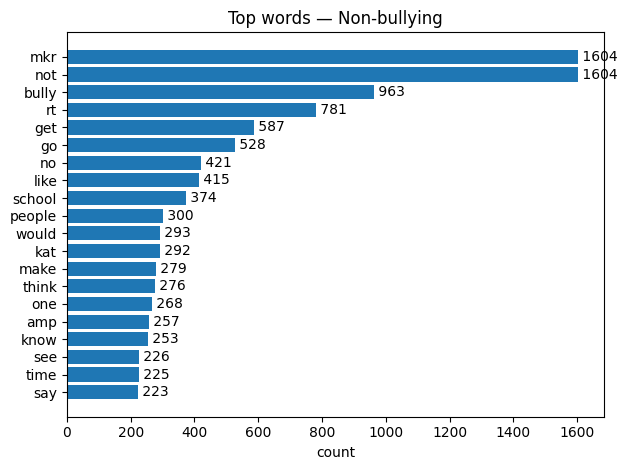

In [26]:
def top_words(df, label_value, n=20):
    texts = df.loc[df["is_bullying"] == label_value, "lemmatized_text"]
    tokens = " ".join(texts).split()
    # filter out '@user'
    tokens = [t for t in tokens if t != "user"]
    return Counter(tokens).most_common(n)

def plot_top_words(pairs, title):
    if not pairs:
        print("No words to display.")
        return
    words, counts = zip(*pairs)
    words, counts = list(words)[::-1], list(counts)[::-1]  # reverse for nicer barh
    fig, ax = plt.subplots()
    ax.barh(words, counts)
    for y, v in enumerate(counts):
        ax.text(v, y, f" {v}", va="center")
    ax.set_title(title)
    ax.set_xlabel("count")
    plt.tight_layout()
    plt.show()

# top words
top_bully = top_words(cyberbullying_df, 1, n=20)
top_clean = top_words(cyberbullying_df, 0, n=20)

plot_top_words(top_bully, "Top words — Bullying")
plot_top_words(top_clean, "Top words — Non-bullying")

In [27]:
def top_words_by_group(df, text_col, group_col, n=20, ignore=None, groups=None):
    """
    Return {group: [(word, count), ...]} for each group in `group_col`.
    Works for binary or multiclass labels.
    - df[text_col]: cleaned/lemmatized text
    - df[group_col]: class label (int/str)
    - ignore: set of tokens to exclude (e.g., {'@user','user','rt','amp','mkr'})
    - groups: optional iterable to restrict which groups to include / their order
    """
    ignore = ignore or set()
    results = {}
    unique_groups = groups if groups is not None else df[group_col].dropna().unique()
    for g in unique_groups:
        texts = df.loc[df[group_col] == g, text_col].astype(str)
        tokens = " ".join(texts).split()
        tokens = [t for t in tokens if t not in ignore]
        results[g] = Counter(tokens).most_common(n)
    return results

def plot_top_words_grouped(topdict, title_prefix="Top words"):
    """
    Plot each group's top words as a horizontal bar chart.
    `topdict` is the output of top_words_by_group.
    """
    for group, pairs in topdict.items():
        if not pairs:
            print(f"[{group}] No words to display.")
            continue
        words, counts = zip(*pairs)
        words, counts = list(words)[::-1], list(counts)[::-1]
        fig, ax = plt.subplots()
        ax.barh(words, counts)
        for y, v in enumerate(counts):
            ax.text(v, y, f" {v}", va="center")
        ax.set_title(f"{title_prefix} — {group}")
        ax.set_xlabel("count")
        plt.tight_layout()
        plt.show()

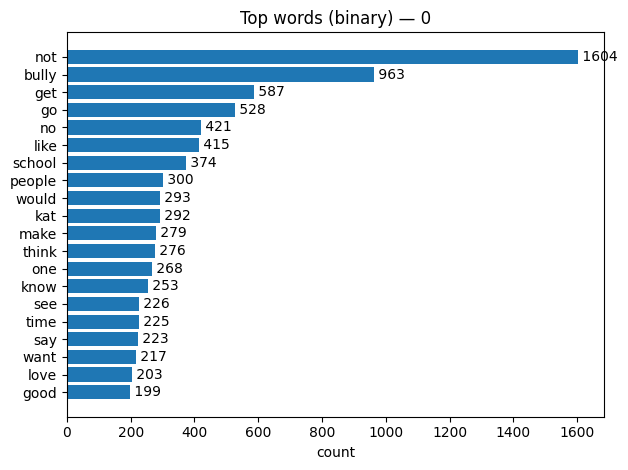

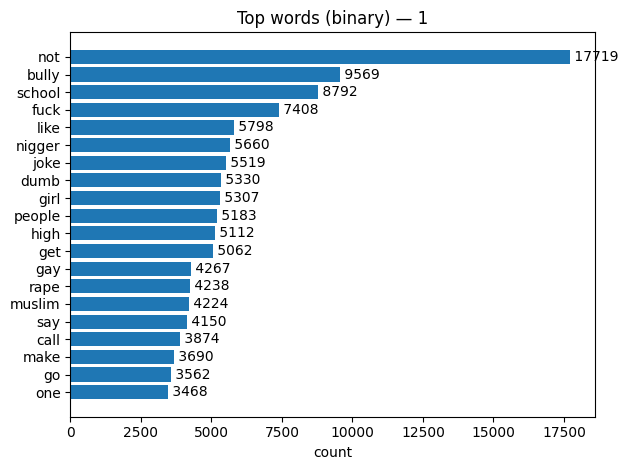

In [28]:
cyberbullying_df["is_bullying"] = (
    cyberbullying_df["cyberbullying_type"] != "not_cyberbullying"
).astype(int)

# Tokens to ignore
ignore_tokens = {"@user", "user", "rt", "amp", "mkr"}

top_bin = top_words_by_group(
    df=cyberbullying_df,
    text_col="lemmatized_text",
    group_col="is_bullying",
    n=20,
    ignore=ignore_tokens,
    groups=[0, 1]  # order: non-bullying, bullying
)

plot_top_words_grouped(top_bin, title_prefix="Top words (binary)")

In [29]:
cleaned_path_cb = DATA_DIR / "cleaned_cyberbullying.parquet"

cleaned_df = cyberbullying_df.copy()
cleaned_df.to_parquet(cleaned_path_cb, engine="fastparquet", index=False)

In [30]:
toxic_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [31]:
toxic_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [32]:
# check for missing values

toxic_df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

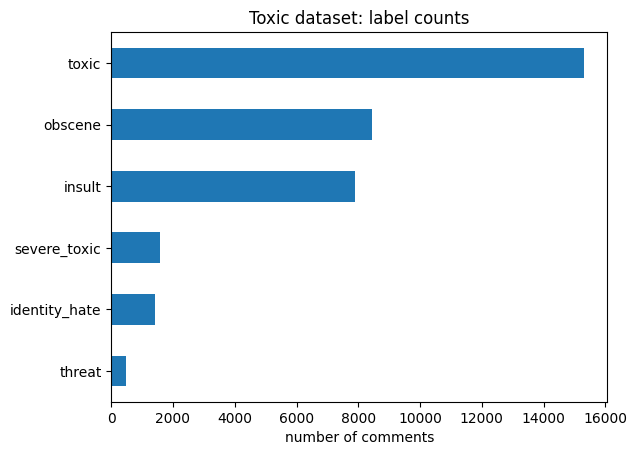

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64


In [33]:
# check class balances 

label_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

# Count how many examples per label
counts = toxic_df[label_cols].sum().sort_values(ascending=True)

counts.plot(kind="barh", title="Toxic dataset: label counts")
plt.xlabel("number of comments")
plt.show()

print(counts)

In [34]:
# how many labels per comment
toxic_df["label_count"] = toxic_df[label_cols].sum(axis=1)
print(toxic_df["label_count"].value_counts().sort_index())

# quick proportion of clean vs toxic
toxic_df["any_toxic"] = (toxic_df["label_count"] > 0).astype(int)
print(toxic_df["any_toxic"].value_counts(normalize=True))

label_count
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64
any_toxic
0    0.898321
1    0.101679
Name: proportion, dtype: float64


In [35]:
# see examples 

def show_examples_multilabel(df, label_col, n=5):
    """Show n random comments for a given toxic label"""
    print(f"\n=== {label_col} ===")
    samples = df.loc[df[label_col]==1, "comment_text"].dropna().sample(n, random_state=42)
    for t in samples:
        print("-", t)

for col in label_cols:
    show_examples_multilabel(toxic_df, col, n=5)


=== toxic ===
- Hi! 

I wanna rape you!
- Terrorize 
I will terrorise you for as long as you live - you are an arrogant, disgusting and rude excuse for a human being & you are going to die soon so I suggest you stop threatening people you bastard.
- Being blocked

So that's your idea of mediation, is it? R Lopez can run amok through Wikipedia with his lying crap, and I get blocked for stating my intention of stopping him unless Wikipedia's rather creaky structures do so. I've seen some silly things since I have been editing here but that would be the silliest.
- Editing Wikipedia 

Fuck You, you anal rapist
- So the fact that the US Govt wants to put some dude in jail for 6 yrs is irrelevant to you?  The fact that the US Govt wants some dude to PAY restitution in over $160,000 to celebrites is irrelevant to you?  You act like that kind of stuff happens every day.  But I challenge you to name one other person that is has happened to, on the scale that this has happened, anywhere in the

In [36]:
toxic_df["clean_text"] = toxic_df["comment_text"].map(lambda x: re.sub(r"\s+"," ", str(x)).strip().lower())

In [37]:
toxic_df["clean_text"]

0         explanation why the edits made under my userna...
1         d'aww! he matches this background colour i'm s...
2         hey man, i'm really not trying to edit war. it...
3         " more i can't make any real suggestions on im...
4         you, sir, are my hero. any chance you remember...
                                ...                        
159566    ":::::and for the second time of asking, when ...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm, theres no actual article for pros...
159569    and it looks like it was actually you who put ...
159570    " and ... i really don't think you understand....
Name: clean_text, Length: 159571, dtype: object

In [38]:
print(toxic_df["any_toxic"].value_counts(normalize=True))

any_toxic
0    0.898321
1    0.101679
Name: proportion, dtype: float64


In [39]:
plot_ignore = {
    # wiki/meta terms
    "wp","wiki", "wikipedia","page","pages","article","articles","talk","edit","edited","editing","user","users",
    "thanks","source","sources","reference","references","section",

    # light discourse fillers you probably don’t want in the top-20s
    "just","like","think","know","did","time","people","make",

    # contractions that slipped past sklearn stopwords
    "don't","i'm","it's","you're","that's","we're","i've","can't","didn't","doesn't","isn't"
}

In [40]:
_URL = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
_MENTION = re.compile(r"@\w+")
_WORD = re.compile(r"[a-z']{2,}", re.IGNORECASE)  # keeps don't, can't, etc.

def simple_pretokenize(text: str) -> str:
    """Turn raw comment into space-separated tokens your function can use."""
    if not isinstance(text, str):
        text = "" if text is None else str(text)
    t = text.lower()
    t = _URL.sub(" url ", t)         # collapse URLs
    t = _MENTION.sub(" user ", t)    # collapse @mentions
    toks = _WORD.findall(t)          # extract words (>=2 chars)
    toks = [tok for tok in toks if tok not in stop_words]  # remove stopwords, keep negations
    toks = collapse_token_runs(toks, max_run=2)
    # normalize html entity leftovers
    toks = ["amp" if tok == "amp" else tok for tok in toks]
    return " ".join(toks)

# Create one pretokenized column
toxic_df["simple_tokens"] = toxic_df["comment_text"].map(simple_pretokenize)

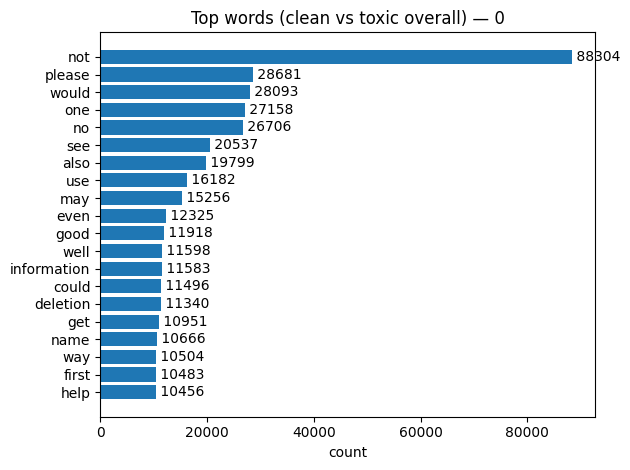

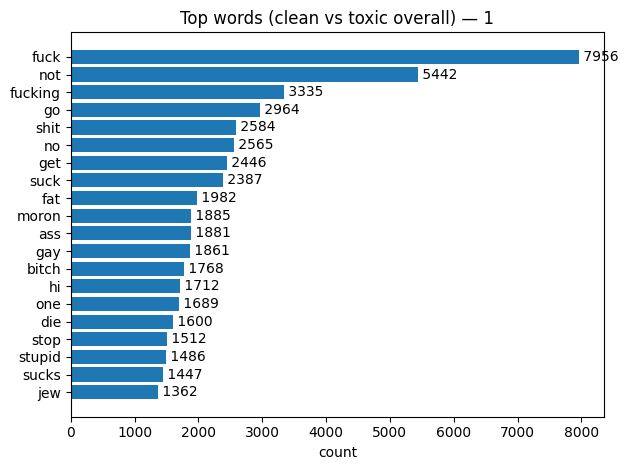

In [41]:
top_any = top_words_by_group(
    df=toxic_df,
    text_col="simple_tokens",  
    group_col="any_toxic",      # 0 = clean, 1 = toxic (any label)
    n=20,
    ignore = plot_ignore,
    groups=[0, 1]
)
plot_top_words_grouped(top_any, title_prefix="Top words (clean vs toxic overall)")

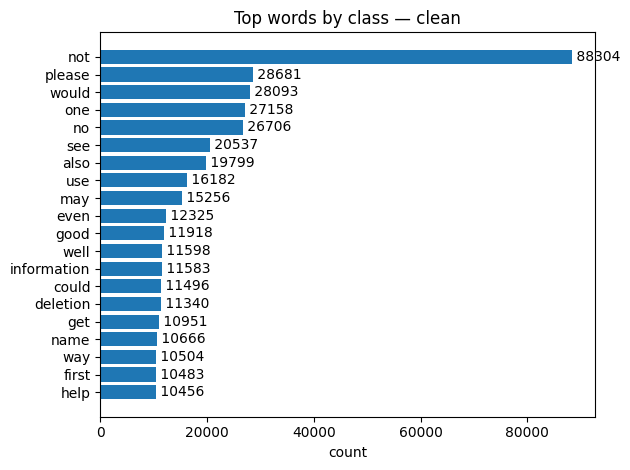

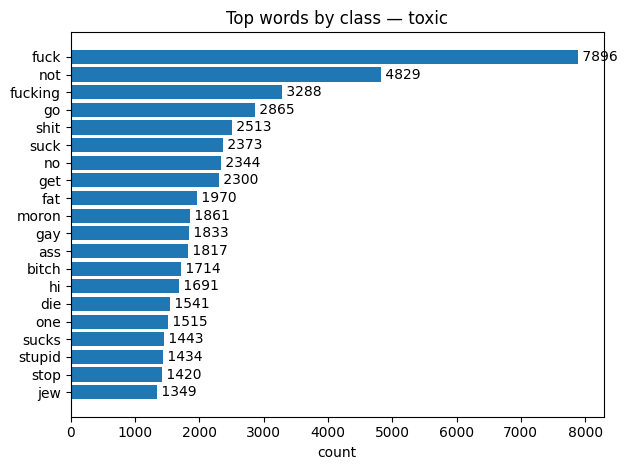

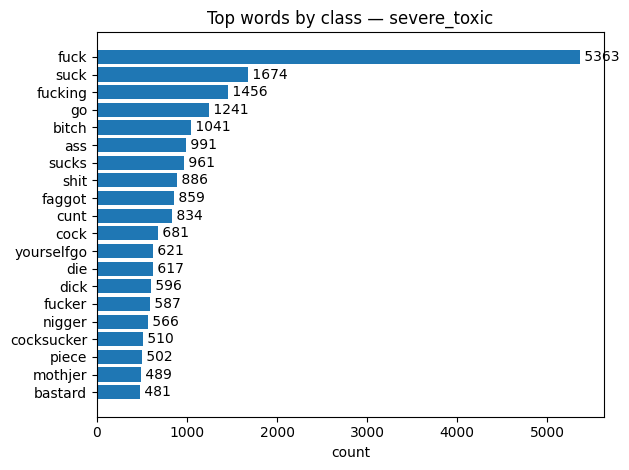

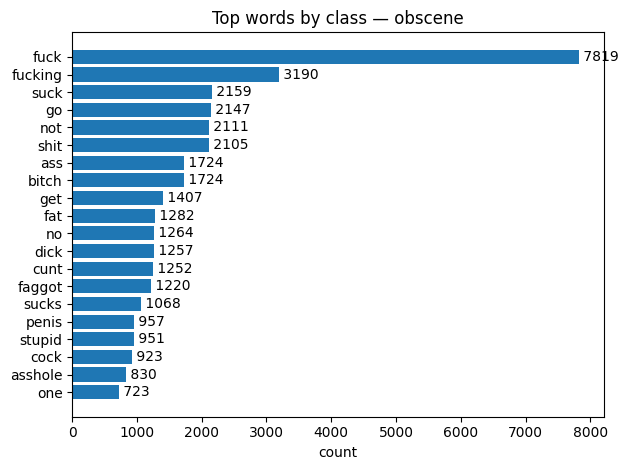

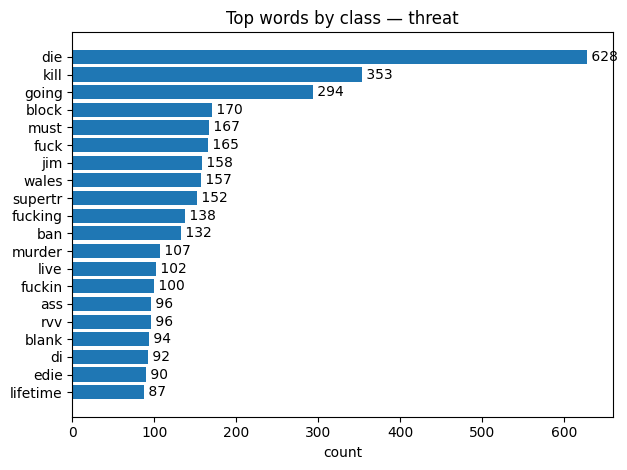

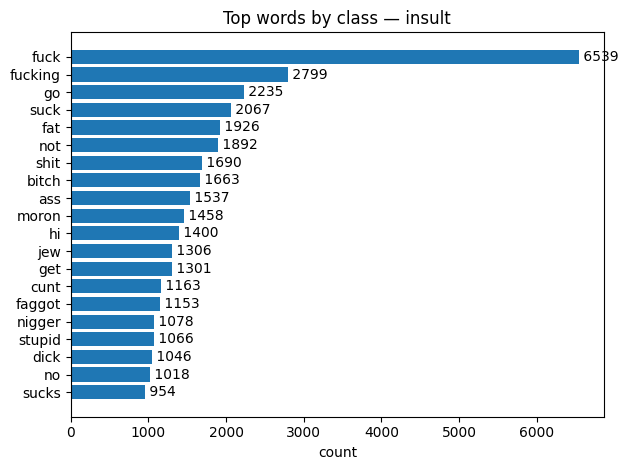

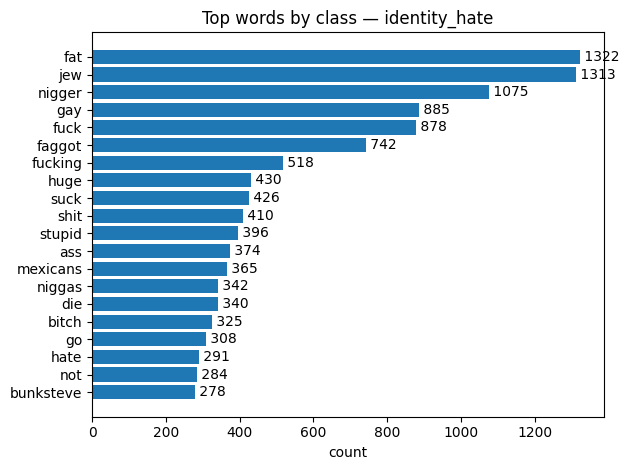

In [42]:
# Clean baseline
clean_df = toxic_df.loc[toxic_df["any_toxic"].eq(0), ["simple_tokens"]].assign(class_label="clean")

# Explode positives so a comment can appear under multiple classes
melted = toxic_df[["simple_tokens"] + label_cols].melt(
    id_vars=["simple_tokens"],
    value_vars=label_cols,
    var_name="class_label",
    value_name="is_positive"
)
long_pos = melted[melted["is_positive"] == 1][["simple_tokens", "class_label"]]

long_all = pd.concat([clean_df, long_pos], ignore_index=True)

order = ["clean"] + label_cols
top_by_class_clean = top_words_by_group(
    df=long_all,
    text_col="simple_tokens",
    group_col="class_label",
    n=20,
    ignore = plot_ignore,
    groups=order
)
plot_top_words_grouped(top_by_class_clean, title_prefix="Top words by class")

The toxic dataset is multilabel and highly imbalanced. Out of 159,571 comments, 89.83% are clean, 3.98% have exactly one label, and 6.18% carry multiple labels. Per-label positives are uneven: toxic (15,294; 9.58%), obscene (8,449; 5.29%), insult (7,877; 4.94%), with much rarer severe_toxic (1,595; 1.00%), identity_hate (1,405; 0.88%), and threat (478; 0.30%). This imbalance will matter for evaluation and potentially for reweighting.

I kept preprocessing minimal to stay fast and transparent on Wikipedia talk text. I lowercased, tokenized with a simple word regex, and removed scikit-learn’s English stopwords. I did not lemmatize this dataset. The cleaned text lives in simple_tokens. I didn’t drop rows or apply social-media–specific normalization since Wikipedia comments rarely contain Twitter-style noise.

For the global view, I created a binary target any_toxic = (label_count > 0). This gives a true clean vs toxic split where 0 = clean (no labels) and 1 = toxic (at least one label). I compared top words between these two groups. This isolates what broadly differentiates toxic language from ordinary discussion without mixing different toxic categories into the “rest”.

For the class view, I used the multilabel setup. I exploded positives so each toxic class gets its own set of comments, and I added a clean baseline made only of comments with label_count = 0. I then ran the same top-words analysis per class (plus clean). This keeps the overlap that’s natural in the data (e.g., a comment can be both toxic and insult) and still lets me see what characterizes each class relative to genuinely clean text.

After reviewing the most frequent words in each class, the following patters come up. The clean group is mostly workflow/meta language: use, good, information, deletion/deleted, help, image, want, new, thank. That’s typical of page maintenance and requests. It’s useful as a baseline but not discriminative.

The toxic group is dominated by profanity and insults. You also see hi—that’s a common pattern (“hi, you’re …”) so it ends up in insults/toxic, not in clean. 

severe_toxic intensifies the same profanity/insult set and adds more violent verbs (die, kill) and harsher forms. 

obscene is heavy on sexual/explicit terms and body-related words. That’s the most class-distinct vocabulary here.

threat surfaces the verbs you expect (die, kill, murder) and moderation vocabulary (block, ban). Tokens like ll (from “I’ll”) and fuckin are artifacts. jim, wales suggest threats aimed at or mentioning the founder during disputes.

insult contains the general insult set plus moron, stupid, fat and (again) hi. It overlaps strongly with toxic/obscene.

identity_hate concentrates group-directed slurs and a few group terms (jew, jewish, mexicans), with general insults mixed in. That’s the most semantically specific class after obscene.

In [43]:
cleaned_path_tx = (DATA_DIR / "cleaned_jigsaw.parquet")
cleaned_toxic = toxic_df.copy()
cleaned_toxic.to_parquet(cleaned_path_tx, engine="fastparquet", index=False)